##### This notebook will walk you step by step through the process of using Segment Anything to generate masks, and then use an OpenCLIP model to detect objects in an image. COCO will be used to generate images, and then evaluate the model's performance.

First, we'll import the necessary libraries and set up the environment.

In [2]:
# import dependencies 
import os 
os.environ ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1500"

# SAM/OpenCLIP dependencies
import torch
import torchvision
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image as Image_Open
from PIL import Image
import open_clip

# COCO dependencies
%matplotlib inline
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from matplotlib.image import imread
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
import json
%pip install ultralyticsplus

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


##### Step 1. Loading the Input image/s

Load COCO and initialize the labels from Val 2017 annotations

In [4]:
# Loading COCO
dataDir='..'
dataType='val2017'
annFile='{}/coco/annotations/instances_{}.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
cocoGt=COCO(annFile)

# display COCO categories and store them into array 'labels'. Tokenize the labels using OpenCLIP
cats = cocoGt.loadCats(cocoGt.getCatIds())
labels = [(cat['id'], cat['name']) for cat in cats]
labels_id = {id : label for id, label in labels}
print(labels_id)

# Tokenize the labels
labels_tokenized = open_clip.tokenize(["This is " + desc[1] for desc in labels])

loading annotations into memory...
Done (t=1.00s)
creating index...
index created!
{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73

Load input image using COCO/Locally

In [5]:
def load_COCO_image():
    # randomly sample an image from COCO Val split 2017
    imgIds = sorted(cocoGt.getImgIds())
    imgIds = imgIds[0:100] # get first 100 images
    image_id = imgIds[np.random.randint(100)] # get a random image id

    # imgIds = coco.getImgIds(imgIds = [324158]) // uncomment to get a specific image
    img = cocoGt.loadImgs(image_id)[0]

    # load and display image
    image = io.imread(img['coco_url']) 

    # tempImg to be cropped for some functions
    tempImg = Image.fromarray(image) 
    tempImg.save('images/{0}.jpg'.format(image_id))

    plt.imshow(tempImg)
    plt.axis('off')
    plt.show()
    return imgIds, image, image_id, tempImg

def load_local_image():
    # load and display image
    image = cv2.imread('images/dog.jpg') # edit this line to load a different image
    image_id = 99999999
    # convert image to be readable by SAM
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    from PIL import Image

    # tempImg to be cropped for some functions
    tempImg = Image.fromarray(image)
    plt.imshow(image)
    plt.axis('off')
    plt.show() 
    return image, image_id, tempImg

##### Step 2. Segment Anything Output

Load Segment Anything/OpenCLIP Models

In [6]:
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Loading SAM Predictors
mask_generator = SamAutomaticMaskGenerator(
    model = sam,
    points_per_side = 32,
    points_per_batch = 64,
    pred_iou_thresh = 0.95,
    stability_score_thresh = 0.95,
    stability_score_offset = 1.0,
    box_nms_thresh = 0.7,
    crop_n_layers = 0,
    crop_nms_thresh = 0.8,
    crop_overlap_ratio = 100 / 1000,
    crop_n_points_downscale_factor = 2,
    point_grids = None,
    min_mask_region_area = 400,
    output_mode = "binary_mask",
) # automatic
# predictor = SamPredictor(sam) # manual

# Loading OpenCLIP model
model, _, transform = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k"
)

05/29/2023 23:22:34 - INFO - root -   Loaded coca_ViT-L-14 model config.
05/29/2023 23:22:41 - INFO - root -   Loading pretrained coca_ViT-L-14 weights (mscoco_finetuned_laion2B-s13B-b90k).


Load functions for showing bbox, generating masks, and then use an OpenCLIP model to detect objects in original image.

In [8]:
# functions for displaying bbox
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def generate_masks(image):
    # Run automatic mask generation
    masks = mask_generator.generate(image)
    length_masks = len(masks)
    return masks, length_masks  

def decode_image(tempImg):
    # generate model for whole image using OpenCLIP and normalize text features
    display_image = tempImg.convert("RGB")
    image_unsqueezed = transform(display_image).unsqueeze(0)

    with torch.no_grad(), torch.cuda.amp.autocast():
        generated = model.generate(image_unsqueezed)
        text_features = model.encode_text(labels_tokenized).float() # initialize text features
        
    text_features /= text_features.norm(dim=-1, keepdim=True) # normalizing text features
        
    decoded = open_clip.decode(generated[0]).split("<end_of_text>")[0].replace("<start_of_text>", "")
    return text_features, decoded

##### Step 3. Cropping the image depending on the SAM output (masks)

Load function for cropping images.


In [9]:
def get_cropped_image(masks, mask, image):
    # convert the XYWH bounding box to LURD format
    bbox_xywh = masks[mask]['bbox'] # the SAM model returns the bounding box in xywh format
    cropped_image = image[bbox_xywh[1]:bbox_xywh[1]+bbox_xywh[3], bbox_xywh[0]:bbox_xywh[0]+bbox_xywh[2]]
    display_image = Image.fromarray(cropped_image).convert("RGB")
    cropped_image = transform(display_image).unsqueeze(0)
    return cropped_image, display_image

##### Step 4. Getting the output label prediction from openCLIP.

Load function to run through all the masks and then crop image to ask OpenClip "This is a photo of what?"

In [10]:
def get_mask_label(masks, mask, text_features, labels, image):    
    # crop the image AKA get the bounding box
    cropped_image, display_image = get_cropped_image(masks, mask, image)
    
    # ask OpenClip "This is a photo of what?"
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(cropped_image).float()
        cropped_decoded = model.generate(cropped_image)
    
    # Normalize the features and calculate the dot product of each pair.
    image_features /= image_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    
    # Get the predicted label
    predicted_label_index = similarity.argmax()
    predicted_label = labels[predicted_label_index]
    
    # get the top 1 probabilities and labels
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(1, dim=-1)
    
    cropped_decoded = open_clip.decode(cropped_decoded[0]).split("<end_of_text>")[0].replace("<start_of_text>", "")
    
    # return the highest probability label and its percentage
    return labels[top_labels[0][0].item()], top_probs[0][0].item(), cropped_decoded

Create an array: label_dict, of dictionaries of labels and their corresponding image_id, category_id, and scores.


In [11]:
def create_dict(length_masks, masks, image, image_id, decoded, text_features, labels):
    label_dict = []
    generated_dict = []

    # iterate through all the masks and get the top 2 labels for each mask
    for mask in range(length_masks):
        label, probability, cropped_decoded = get_mask_label(masks, mask, text_features, labels, image)
        #if label[1] in decoded or label[1] in cropped_decoded:
        label_dict.append({"image_id": image_id, "category_id": label[0], 
                            "bbox": masks[mask]['bbox'], "score": round(probability, 3)
                            })
        generated_dict.append(cropped_decoded)
    return label_dict, generated_dict

Run through steps 1 to 4.   
1. Load the input image/s
2. Generate Masks using Segment Anything
3. Decode the image using OpenCLIP and normalize the text_features
4. Get the output label prediction from OpenCLIP in cocoEval format. Store the results in label_dict.

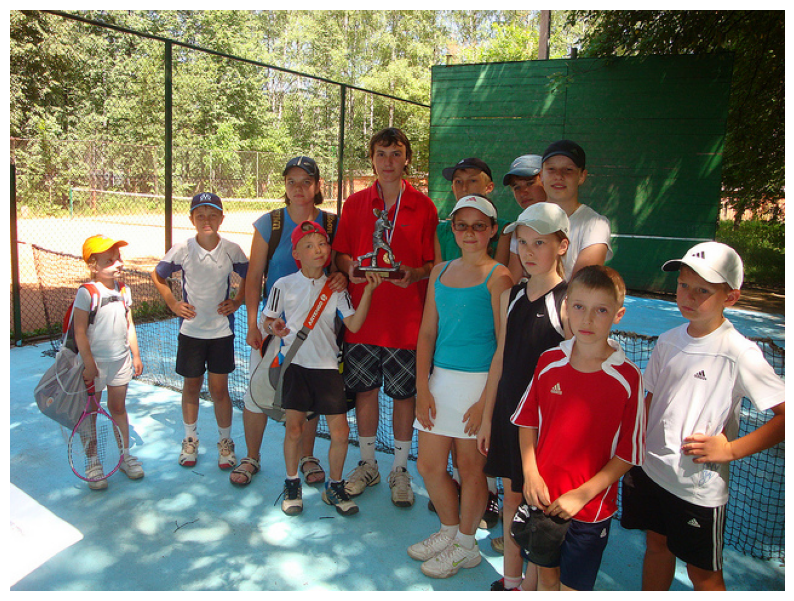

Image ID: 1000
Number of masks: 79
Image description: a group of young tennis players posing for a picture . 
[{'image_id': 1000, 'category_id': 43, 'bbox': [345, 37, 250, 195], 'score': 0.867}, {'image_id': 1000, 'category_id': 42, 'bbox': [0, 391, 59, 84], 'score': 0.303}, {'image_id': 1000, 'category_id': 1, 'bbox': [460, 211, 48, 33], 'score': 0.35}, {'image_id': 1000, 'category_id': 1, 'bbox': [414, 272, 109, 151], 'score': 0.55}, {'image_id': 1000, 'category_id': 1, 'bbox': [349, 208, 56, 90], 'score': 0.582}, {'image_id': 1000, 'category_id': 1, 'bbox': [392, 224, 67, 173], 'score': 0.521}, {'image_id': 1000, 'category_id': 1, 'bbox': [550, 211, 52, 59], 'score': 0.696}, {'image_id': 1000, 'category_id': 1, 'bbox': [137, 267, 48, 36], 'score': 0.36}, {'image_id': 1000, 'category_id': 19, 'bbox': [538, 192, 67, 39], 'score': 0.389}, {'image_id': 1000, 'category_id': 1, 'bbox': [120, 188, 76, 83], 'score': 0.485}, {'image_id': 1000, 'category_id': 1, 'bbox': [461, 0, 178, 166], 's

In [14]:
imgIds, image, image_id, tempImg = load_COCO_image()
print("Image ID:", image_id)
masks, length_masks = generate_masks(image)
print("Number of masks:", length_masks)
text_features, decoded = decode_image(tempImg)
print("Image description:", decoded)
label_dict, generated_dict = create_dict(length_masks, masks, image, image_id, decoded, text_features, labels)
print(label_dict)

Postprocess the labels in the array: label_dict (remove redundant boxes and low score masks). 

In [15]:
def is_contained(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    return x1 >= x2 and y1 >= y2 and x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2

def postprocess(label_dict):
    result = []
    label_dict.sort(key=lambda x: x['bbox'][2] * x['bbox'][3])
    for i in range(len(label_dict)):
        keep = True
        for j in range(len(label_dict)):
            if i != j:
                if label_dict[i]['category_id'] == label_dict[j]['category_id']:
                    if is_contained(label_dict[i]['bbox'], label_dict[j]['bbox']) and label_dict[i]['score'] < label_dict[j]['score']:
                        keep = False
                        break
        if keep:
            result.append(label_dict[i])

    label_dict = result
    label_dict = [label for label in label_dict if label["score"] >= 0.6]
    return label_dict

label_dict = postprocess(label_dict)

Show the predictions side by side. From the left:  predicted labels , COCO ground truth.

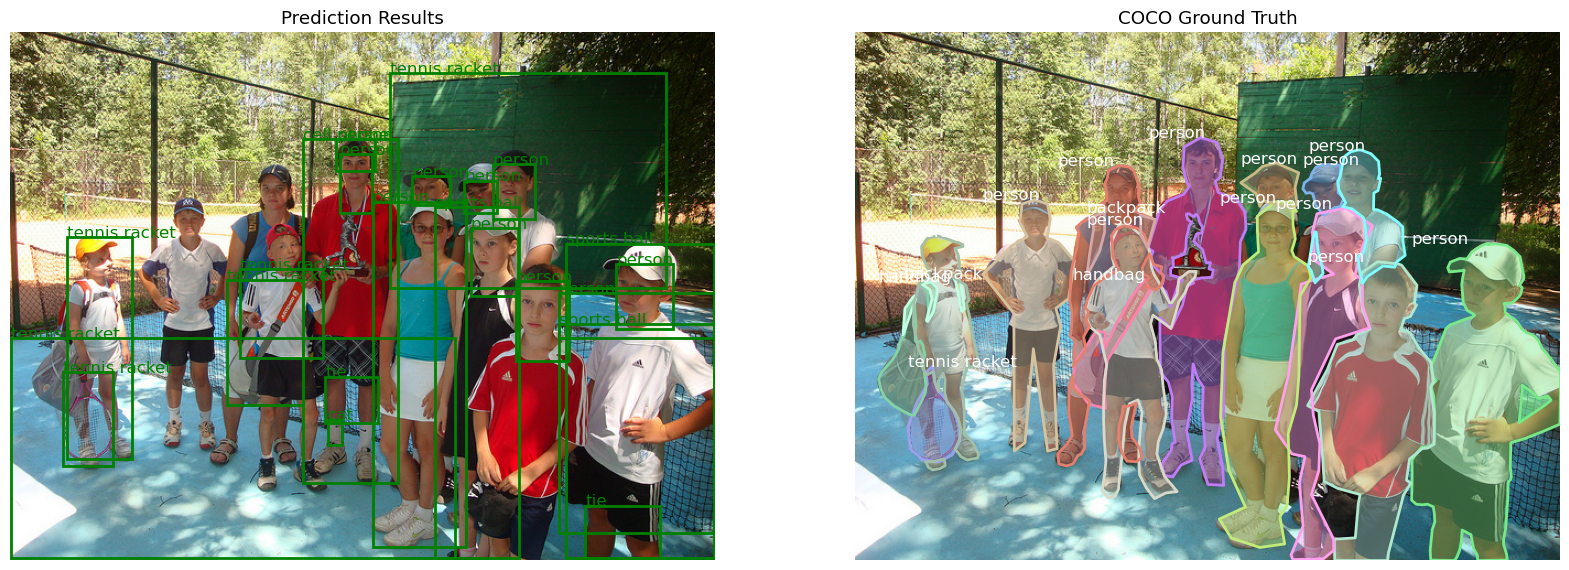

In [44]:
# create a figure with two subplots arranged side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title('Prediction Results')
ax2.set_title('COCO Ground Truth')
# plot the first figure on the first subplot
ax1.imshow(image)
for label in label_dict:
    bbox_xywh = label['bbox']
    cropped_image = [bbox_xywh[0], bbox_xywh[1], bbox_xywh[0] + bbox_xywh[2], bbox_xywh[1] + bbox_xywh[3]]
    bbox = torch.tensor(cropped_image)
    show_box(bbox.cpu().numpy(), ax1)
    # display the category_id at the top-left corner of the bounding box
    category = labels_id.get(label['category_id'])
    ax1.text(bbox_xywh[0], bbox_xywh[1], str(category), color='green', fontsize=12)
ax1.axis('off')

# plot the second figure on the second subplot
ann_ids = cocoGt.getAnnIds(imgIds=image_id)
anns = cocoGt.loadAnns(ann_ids)
img = cocoGt.loadImgs(image_id)[0]
I = io.imread(img['coco_url'])
ax2.imshow(I)
cocoGt.showAnns(anns)
for ann in anns:
    # get the category label for this annotation
    cat_id = ann['category_id']
    cat = cocoGt.loadCats(cat_id)[0]
    cat_label = cat['name']
    
    # display the category label at the top-left corner of the bounding box
    bbox = ann['bbox']
    plt.gca().text(bbox[0], bbox[1], cat_label, color='white', fontsize=12)
ax2.axis('off')

# display the figure
plt.show()

Ultralytics YOLOv8.0.43  Python-3.9.16 torch-2.0.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8191MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

0: 480x640 12 persons, 1 backpack, 1 tennis racket, 10.0ms
Speed: 0.0ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


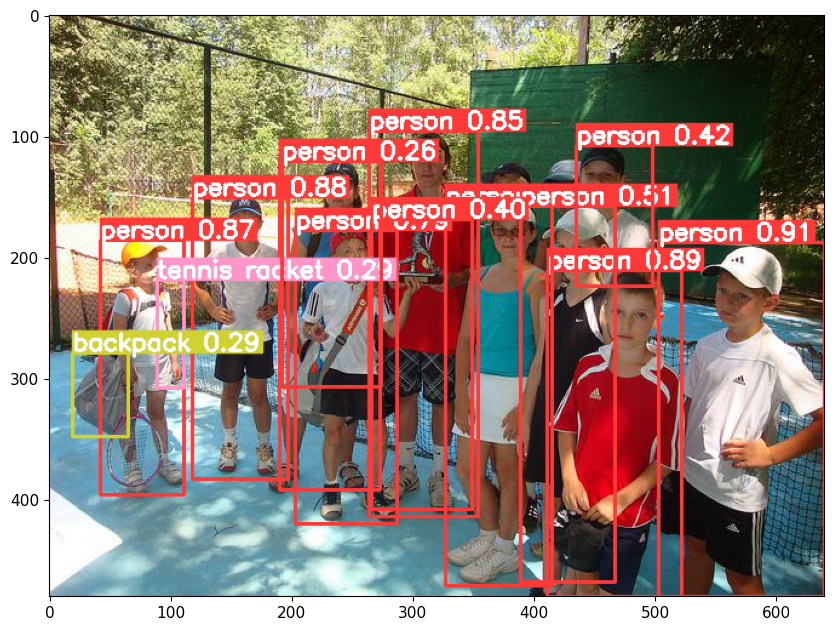

In [47]:
# Show predictions from YoloV8
from ultralyticsplus import YOLO, render_result

# load model
model = YOLO('yolov8n.pt')
# set image
image2 = 'images/{}.jpg'.format(image_id)

# perform inference
results = model.predict(image)
render = render_result(model=model, image=image2, result=results[0])

# show render using plt
plt.imshow(render)
plt.show()

##### Step 5. Evaluate the models performance based on COCO Ground Truth.

In [48]:
# initialize COCO detections api
annType = 'bbox'
resFile='../coco/results/instances_val2017_fakebbox100_results.json' # edit this to your own path

# Check if file exists
if not os.path.exists(resFile):
    # Create file
    with open(resFile, 'w') as f:
        json.dump([], f)

# Read existing data from the file
with open(resFile, 'r') as f:
    data = json.load(f)

# Update data with new data
data.append(label_dict)

# Write updated data back to the file
with open(resFile, 'w') as f:
    json.dump(label_dict, f)

In [49]:
# load results in COCO evaluation tool    
cocoDt=cocoGt.loadRes(resFile)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


In [50]:
# running evaluation
cocoEval = COCOeval(cocoGt,cocoDt,annType)
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.26s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.004
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100